# Finding the suspect

<a href="https://en.wikipedia.org/wiki/Facial_composite">Facial composites</a> are widely used in forensics to generate images of suspects. Since victim or witness usually isn't good at drawing, computer-aided generation is applied to reconstruct the attacker's face. One of the most commonly used techniques is evolutionary systems that compose the final face from many predefined parts.

In this project, we will try to implement a simple app for creating a facial composite that will be able to construct desired faces (faces with particular properties, such as smiley, dark/bright color, dark/bright hair etc.) without explicitly providing databases of templates. We will apply Variational Autoencoders and Gaussian processes for this task. 


### Setup
Load auxiliary files and then install and import the necessary libraries.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
#from IPython.display import clear_output
import tensorflow as tf
import GPy
import GPyOpt
import keras
from keras.layers import Input, Dense, Lambda, InputLayer, concatenate, Activation, Flatten, Reshape
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D, Deconv2D
from keras.losses import MSE
from keras.models import Model, Sequential
from keras import backend as K
from keras import metrics
from keras.datasets import mnist
from keras.utils import np_utils
from tensorflow.python.framework import ops
from tensorflow.python.framework import dtypes
import utils
import os
%matplotlib inline

Using TensorFlow backend.


In [2]:
GPyOpt.__version__

'1.2.6'

## Model description
We will first train variational autoencoder on face images to compress them to low dimension. One important feature of VAE is that constructed latent space is dense. That means that we can traverse the latent space and reconstruct any point along our path into a valid face.

Using this continuous latent space we can use Bayesian optimization to maximize some similarity function between a person's face in victim/witness's memory and a face reconstructed from the current point of latent space. Bayesian optimization is an appropriate choice here since people start to forget details about the attacker after they were shown many similar photos. Because of this, we want to reconstruct the photo with the smallest possible number of trials.

## Generating faces

We will need to use some database of face images. There are multiple datasets available on the web that we can use: for example, <a href="http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html">CelebA</a> or <a href="http://vis-www.cs.umass.edu/lfw/">Labeled Faces in the Wild</a>. We used Aligned & Cropped version of CelebA that you can find <a href="https://www.dropbox.com/sh/8oqt9vytwxb3s4r/AADSNUu0bseoCKuxuI5ZeTl1a/Img?dl=0&preview=img_align_celeba.zip">here</a> to pretrain VAE model.

In [3]:
latent_size = 8

In [4]:
vae, encoder, decoder = utils.create_vae(batch_size=128, latent=latent_size)
vae.load_weights('CelebA_VAE_small_8.h5')

In [5]:
K.set_learning_phase(False)

#### Draw 25 samples from trained VAE model
Let's look at some samples from the trained model. We will only need a decoder to reconstruct samples from a latent space. 
To generate samples, we need pass some normal (distribution) samples from the latent space to the decoder.


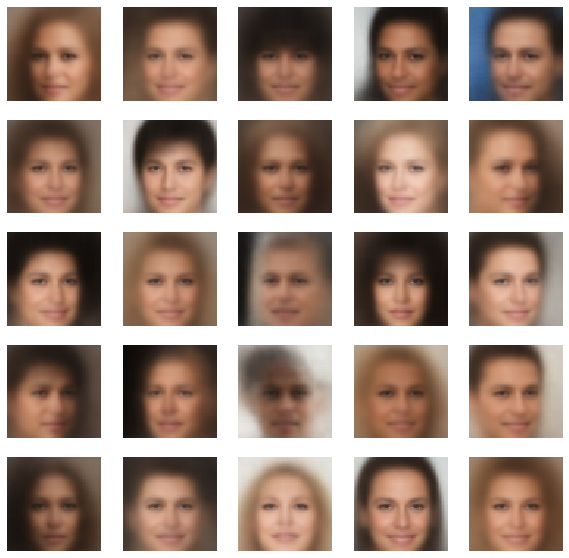

In [7]:
### TODO: Draw 25 samples from VAE here
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    t_sample = K.random_normal([2,latent_size],mean=0.0,stddev=1.0,dtype=tf.float32)
    image = decoder(t_sample)
    plt.imshow(K.eval(tf.clip_by_value(image[0], 0, 1)))
    plt.axis('off')

## Search procedure

Now that we have a way to reconstruct images, we need to set up an optimization procedure to find a person that will be the most similar to the one we are thinking about. To do so, we need to set up some scoring utility. Imagine that we want to generate an image of Brad Pitt. We start with a small number of random samples, say 5, and rank them according to their similarity to your vision of Brad Pitt: 1 for the worst, 5 for the best. We then rate image by image using GPyOpt that works in a latent space of VAE. For the new image, we need to somehow assign a real number that will show how good this image is. The simple idea is to ask a user to compare a new image with previous images (along with their scores). A user then enters score to a current image.

This type of scoring has a lot of drawbacks and is not the best choice. But we follow it for the sake of simplicity over some more sophisticated and heavier architechtures. 

Let's get started:

In [22]:
class FacialComposit:
    def __init__(self, decoder, latent_size):
        self.latent_size = latent_size
        self.decode = decoder
        self.counter = 0
        self.samples = None
        self.images = None
        self.rating = None

    def _get_image(self, latent):
        img = K.eval(self.decode(tf.Variable(latent[None,:],dtype=tf.float32)))
        img = np.clip(img, 0, 1)
        return img

    @staticmethod
    def _show_images(images, titles):
        assert len(images) == len(titles)
        #clear_output()
        plt.figure(figsize=(3*len(images), 3))
        n = len(titles)
        for i in range(n):
            plt.subplot(1, n, i+1)
            plt.imshow(images[i])
            plt.title(str(titles[i]))
            plt.axis('off')
        plt.show()

    @staticmethod
    def _draw_border(image, w=2):
        bordred_image = image.copy()
        bordred_image[:, :w] = [1, 0, 0]
        bordred_image[:, -w:] = [1, 0, 0]
        bordred_image[:w, :] = [1, 0, 0]
        bordred_image[-w:, :] = [1, 0, 0]
        return bordred_image

    def query_initial(self, n_start=5, select_top=None):
        
        '''
        Creates initial points for Bayesian optimization
        Generate *n_start* random images and asks user to rank them.
        Gives maximum score to the best image and minimum to the worst.
        :param n_start: number of images to rank initialy.
        :param select_top: number of images to keep
        '''
        images = []
        samples = []
        for i in range(n_start):
            sample = np.random.normal(size=(latent_size),loc=0.0,scale=1.0) 
            images.append(self._get_image(sample)[0]) 
            samples.append(sample)


        titles = np.arange(n_start)
        self._show_images(images, titles)

        rates = input('''Please rate the images in order with numbers
                         from 1 to 5 without any space in between. 
                         Use 1 for the worst and 5 for the  best similarity.''')
        rating = [int(c) for c in rates] 


        top_rates = sorted(enumerate(rating), key = lambda x:x[1], reverse=True)[:select_top]
        top_indices = [rate[0] for rate in top_rates]
        self.samples = np.array(samples)[top_indices]
        self.images = np.array(images)[top_indices]
        self.rating = np.array(rating)[top_indices]
        
        
    def evaluate(self, candidate):
        '''
        Queries candidate vs known image set.
        Adds candidate into images pool.
        :param candidate: latent vector of size 1xlatent_size
        '''
        initial_size = len(self.images)
        
        if self.counter == 0:
            print('Here are some images with their ranking:')
            self._show_images(self.images[:3], self.rating[:3])
            self.counter += 1

        self.samples = np.vstack((self.samples, candidate[0]))
        
        new_image = self._get_image(candidate[0])

        self.images = np.vstack((self.images, new_image))
        self._show_images(new_image, ['Rate it!'])

        new_rate = int(input('''Please rate the above image with numbers
                      from 1 to 5. 
                      Use 1 for the worst and 5 for the  best similarity.'''))
        
        self.rating = np.hstack((self.rating, new_rate))
     
        candidate_rating = new_rate 
        
                
        assert len(self.images) == initial_size + 1
        assert len(self.rating) == initial_size + 1
        assert len(self.samples) == initial_size + 1

        return candidate_rating

    def optimize(self, n_iter=10, w=4, acquisition_type='MPI', acquisition_par=0.3):
        if self.samples is None:
            self.query_initial()

        bounds = [{'name': 'z_{0:03d}'.format(i),
                   'type': 'continuous',
                   'domain': (-w, w)} 
                  for i in range(self.latent_size)]
        
        optimizer = GPyOpt.methods.BayesianOptimization(f=self.evaluate, domain=bounds,
                                                        acquisition_type = acquisition_type,
                                                        acquisition_par = acquisition_par,
                                                        exact_eval=False, # Since we are not sure
                                                        model_type='GP',
                                                        X=self.samples,
                                                        Y=self.rating[:, None],
                                                        maximize=True)
        optimizer.run_optimization(max_iter=n_iter, eps=-1)

    def get_best(self):
        index_best = np.argmax(self.rating)
        return self.images[index_best]

    def draw_best(self, title=''):
        index_best = np.argmax(self.rating)
        image = self.images[index_best]
        plt.imshow(image)
        plt.title(title)
        plt.axis('off')
        plt.show()

So this application asks the user to rate new images while it shows the rating for 3 referenec images of highest ratings.
One of the limitations of this approach is the accuracy of rating for new images that is relied on the user's view rather than an rigorous mathematical formulation.

## Testing your algorithm

In these sections, we will apply the implemented app to search for different people. Each task will aim to generate images that will have some property like "dark hair" or "mustache". 

#### Task 3.1: Finding person with darkest hair (3 points)

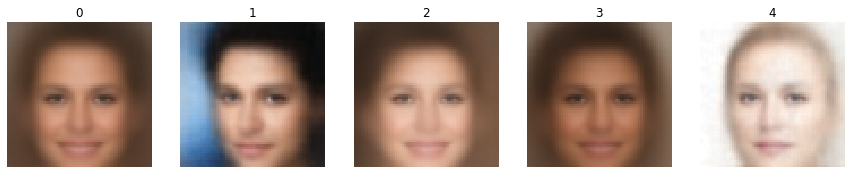

Please rate the images in order with numbers
                         from 1 to 5 without any space in between. 
                         Use 1 for the worst and 5 for the  best similarity.35341
Here are some images with their ranking:


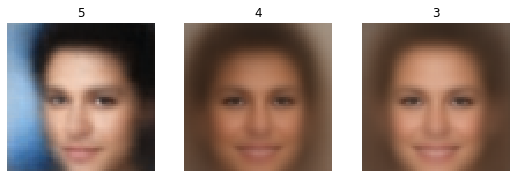

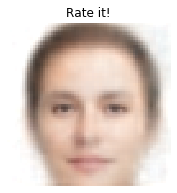

Please rate the above image with numbers
                      from 1 to 5. 
                      Use 1 for the worst and 5 for the  best similarity.3


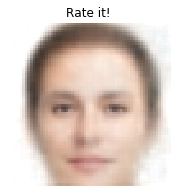

Please rate the above image with numbers
                      from 1 to 5. 
                      Use 1 for the worst and 5 for the  best similarity.4


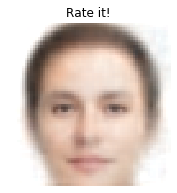

Please rate the above image with numbers
                      from 1 to 5. 
                      Use 1 for the worst and 5 for the  best similarity.4


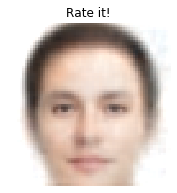

Please rate the above image with numbers
                      from 1 to 5. 
                      Use 1 for the worst and 5 for the  best similarity.5


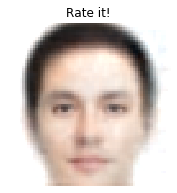

Please rate the above image with numbers
                      from 1 to 5. 
                      Use 1 for the worst and 5 for the  best similarity.5


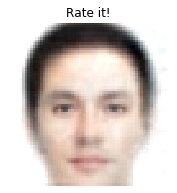

Please rate the above image with numbers
                      from 1 to 5. 
                      Use 1 for the worst and 5 for the  best similarity.5


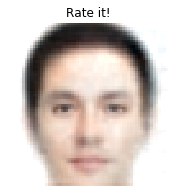

Please rate the above image with numbers
                      from 1 to 5. 
                      Use 1 for the worst and 5 for the  best similarity.5


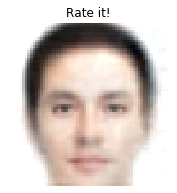

Please rate the above image with numbers
                      from 1 to 5. 
                      Use 1 for the worst and 5 for the  best similarity.5


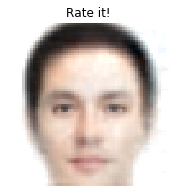

Please rate the above image with numbers
                      from 1 to 5. 
                      Use 1 for the worst and 5 for the  best similarity.5


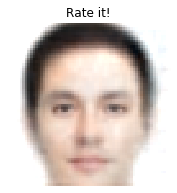

Please rate the above image with numbers
                      from 1 to 5. 
                      Use 1 for the worst and 5 for the  best similarity.5


In [23]:
composit = FacialComposit(decoder, 8)
composit.optimize()

As it can be seen, our basic application can easily recognize the we are looking for the darkest hair color. 

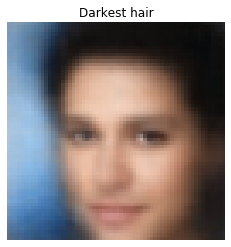

In [24]:
composit.draw_best('Darkest hair')

#### Task 3.2. Finding person with the widest smile (3 points)

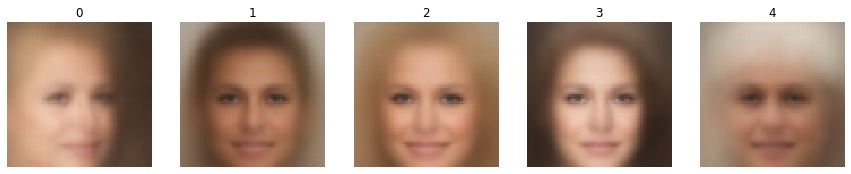

Please rate the images in order with numbers
                         from 1 to 5 without any space in between. 
                         Use 1 for the worst and 5 for the  best similarity.33513
Here are some images with their ranking:


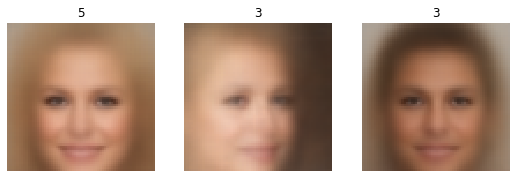

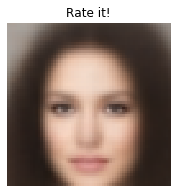

Please rate the above image with numbers
                      from 1 to 5. 
                      Use 1 for the worst and 5 for the  best similarity.2


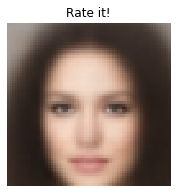

Please rate the above image with numbers
                      from 1 to 5. 
                      Use 1 for the worst and 5 for the  best similarity.2


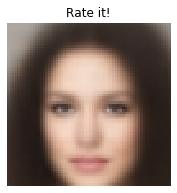

Please rate the above image with numbers
                      from 1 to 5. 
                      Use 1 for the worst and 5 for the  best similarity.2


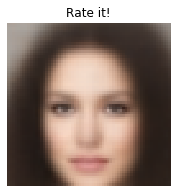

Please rate the above image with numbers
                      from 1 to 5. 
                      Use 1 for the worst and 5 for the  best similarity.2


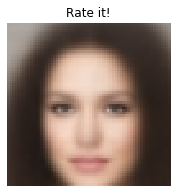

Please rate the above image with numbers
                      from 1 to 5. 
                      Use 1 for the worst and 5 for the  best similarity.2


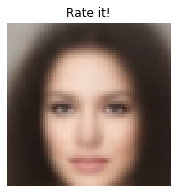

Please rate the above image with numbers
                      from 1 to 5. 
                      Use 1 for the worst and 5 for the  best similarity.2


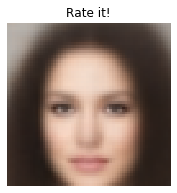

Please rate the above image with numbers
                      from 1 to 5. 
                      Use 1 for the worst and 5 for the  best similarity.2


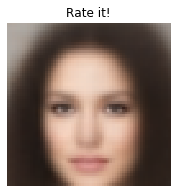

Please rate the above image with numbers
                      from 1 to 5. 
                      Use 1 for the worst and 5 for the  best similarity.2


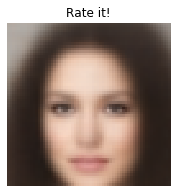

Please rate the above image with numbers
                      from 1 to 5. 
                      Use 1 for the worst and 5 for the  best similarity.2


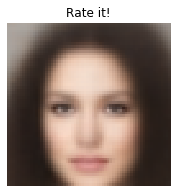

Please rate the above image with numbers
                      from 1 to 5. 
                      Use 1 for the worst and 5 for the  best similarity.2


In [25]:
composit = FacialComposit(decoder, 8)
composit.optimize()

On the other hand, our simple search engine is not efficient here for finding the widest smile. We need to design a more accurate searching engine that can properly score many images (not just a few). One option is to find a similarity function that can recognize more details of a picture.  

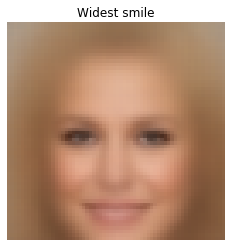

In [27]:
composit.draw_best('Widest smile')